sources are based on: https://github.com/AllenInstitute/MicronsBinder/tree/master/notebooks/mm3_intro 

# setting up workspace

In [1]:
# import stuff
from caveclient import CAVEclient
import pandas as pd
import numpy as np
import scipy.spatial as sci_spatial
from scipy.spatial import distance_matrix
from tqdm import tqdm
import csv
import pickle #how to use pickle: https://www.datacamp.com/tutorial/pickle-python-tutorial 
import utils
from nglui import statebuilder
import plotly.figure_factory as ff
import networkx as nx
from itertools import chain, combinations
from scipy.cluster.hierarchy import dendrogram
import random
import statistics
import matplotlib.pyplot as plt
import sklearn

client = CAVEclient()

In [2]:
#load up the dataset through query # no query for minnie35: https://github.com/seung-lab/CAVEclient/issues/49 
client = CAVEclient('minnie65_public_v117') #minnie65_public_v117
# client2 = CAVEclient('minnie35_public_v0 ')

# Load all the proofreaded neurons (with different proofreadbility)
prf_df=client.materialize.query_table('proofreading_status_public_release')

statuses_axon = pd.Series(prf_df.loc[:,"status_axon"])
raw_valid_ids = pd.Series(prf_df.loc[:,"valid_id"])
# verify that pt_root_id == valid_id for clean axons

valid_ids = []
for i in range(len(statuses_axon)):
    valid_ids.append(raw_valid_ids[i])
print(len(valid_ids))

verified_ids_len = 0 
for i in range(len(valid_ids)):
    verified_ids_len += 1
print('verified_ids_len', verified_ids_len)

neuron_type_df_coverall_notallright=client.materialize.query_table('allen_soma_ei_class_model_v1')
ids_of_coverall_notallright_ser = pd.Series(neuron_type_df_coverall_notallright.loc[:,"pt_root_id"])
types_of_coverall_notallright_ser = pd.Series(neuron_type_df_coverall_notallright.loc[:,"cell_type"])

# valid_ids
ext_neuron_valid_ids_lst = []
for i in range(len(ids_of_coverall_notallright_ser)):
    if ids_of_coverall_notallright_ser[i] in valid_ids and types_of_coverall_notallright_ser[i] == 'excitatory':
        ext_neuron_valid_ids_lst.append(ids_of_coverall_notallright_ser[i])
print(len(ext_neuron_valid_ids_lst))


valid_ids = ext_neuron_valid_ids_lst

# setting up str_num_2_presypneuron and presypneuron_2_str_num to simplify the representation of pre-syp-neuron-id
# using string number (e.g.: "20") to correspond to the long-digit id of the pre-syp-neuron 
num_rep_2_presypneuron = {}
presypneuron_2_num_rep = {}
for i, the_id in enumerate(valid_ids):
    num_rep_2_presypneuron[i] = the_id
    presypneuron_2_num_rep[the_id] = i

601
verified_ids_len 601
492


# working on sheezneat

#To get a seq of means and std of a given length
#create containers for means and std 
#have to go through all the dict. and select the key and then you get the list of vals

In [3]:
# num_seqs_dict_w_diff_num_neurons_lst = [num_seqs_of_30_neurons, num_seqs_of_60_neurons, num_seqs_of_120_neurons, num_seqs_of_240_neurons, num_seqs_of_480_neurons]

In [4]:
# means = {'len3_means':[], 'len4_means':[], 'len5_means':[], 'len6_means':[]}
# stds = {'len3_stds':[], 'len4_stds':[], 'len5_stds':[], 'len6_stds':[]}
# for seq_dict_w_num_neurons in num_seqs_dict_w_diff_num_neurons_lst:
#     for i in range(3, 7):
#         the_len = 'len' + str(i)
#         num_seqs_vals = seq_dict_w_num_neurons[the_len]
#         mean_key = 'len' + str(i) + '_means'
#         std_key = 'len' + str(i) + '_stds'
#         mean_val = statistics.mean(num_seqs_vals)
#         std_val = statistics.pstdev(num_seqs_vals)
#         means[mean_key].append(mean_val)
#         stds[std_key].append(std_val)

In [5]:
# df_1 = pd.DataFrame({ #from kd tree with radius = 10um
#     'insert': [30, 60, 120, 240, 480, 30, 60, 120, 240, 480, 30, 60, 120, 240, 480, 30, 60, 120, 240, 480],
#     'mean': [13.25, 27.65, 65.9, 187.65, 551.05,
#              3.8, 8.65, 17.6, 48.65, 142.95,
#             1.65, 3.35, 7.35, 19.8, 54.4,
#             0.6, 1.7, 2.5, 6.2, 17.05],
#     'std': [2.48746859276655, 5.121279137090655, 7.034912934784623, 9.561772848169946, 7.921331958704925,
#             2.249444375840399, 2.6509432283623124, 4.223742416388575, 7.702434680021636, 4.200892762258994, 
#             1.1947803145348521, 1.6209565077447328, 2.5548972582082436, 4.214261501141095, 2.2671568097509267,
#             0.58309518948453, 1.1445523142259597, 1.5968719422671311, 1.8867962264113207, 1.2031209415515964
#            ],
#     'length': ['len3', 'len3', 'len3', 'len3', 'len3',
#                'len4', 'len4', 'len4', 'len4', 'len4',
#               'len5', 'len5', 'len5', 'len5', 'len5',
#               'len6', 'len6', 'len6', 'len6', 'len6']})

In [6]:
# df_2 = pd.DataFrame({ #from kd tree with radius = 5um
#     'insert': [30, 60, 120, 240, 480, 30, 60, 120, 240, 480, 30, 60, 120, 240, 480, 30, 60, 120, 240, 480],
#     'mean': [8.45, 19.25, 41.35, 101.55, 280.4,
#              1.5, 3.6, 8.35, 21.25, 50.5,
#             0.5, 0.85, 2.6, 5.6, 15.55,
#             0.2, 0.2, 0.8, 1.6, 4.85],
#     'std': [3.6670833096617805, 4.61383788185064, 6.279132105633708, 11.083659143080862, 6.232174580353153,
#             1.3601470508735443, 1.9078784028338913, 2.868361901852693, 3.7399866309921483, 1.6278820596099706, 
#             0.7416198487095663, 0.7262919523166975, 1.5297058540778357, 1.8, 0.7399324293474371,
#             0.5099019513592785, 0.4, 0.4, 0.9695359714832659, 0.3570714214271425
#            ],
#     'length': ['len3', 'len3', 'len3', 'len3', 'len3',
#                'len4', 'len4', 'len4', 'len4', 'len4',
#               'len5', 'len5', 'len5', 'len5', 'len5',
#               'len6', 'len6', 'len6', 'len6', 'len6']})

In [7]:
# fig, ax = plt.subplots()
# for key, group in df_1.groupby('length'):
#     if key != 'len6':
#         group.plot('insert', 'mean', label=key, ax=ax)
#         plt.fill_between([30, 60, 120, 240, 480], np.clip(np.array(group['mean'])-np.array(group['std']), 0, None), np.array(group['mean'])+np.array(group['std']), alpha=0.1)

# plt.xscale("log")
# plt.yscale("log")
# plt.ylim([1e-1, 500])

# plt.show()

In [8]:
# print('using radius = 5um for the kd tree')
# legends = []
# for i in range(3, 7):
#     occurences = [len(seqs_with_post_neuron_lst[key]) for key in seqs_with_post_neuron_lst if len(key)==i]
#     occ_array = np.array(occurences)
#     print('ttl number of seqs with len' + str(i) + ' = ' + str(len(occ_array)))
#     plt.plot(np.sort(occ_array), np.linspace(0, 1, len(occ_array), endpoint=False))
#     plt.ylim([0.5, 1])
#     plt.xscale("log")
#     legends.append('len' + str(i))
# plt.legend(legends)
# plt.title("cdf of number of occurance on log scale")
# plt.show()

In [10]:
seqs_with_post_neuron_lst = utils.load_obj_from_filename('seqs_with_post_neuron_lst_10um')
syp_ids_of_seqs_with_post_neuron_lst = utils.load_obj_from_filename('syp_ids_of_seqs_with_post_neuron_lst_10um')

In [11]:
ns = np.round(np.logspace(np.log10(60), np.log10(480), 8, base=10)).astype(int)
# ns = [ 60,  81, 109, 120, 197, 265, 357, 480]
q = 101
cts = np.zeros((3,8,q))
for k,p in enumerate([3, 4, 5]):
    a_lst = utils.get_seq_with_length_n_of_unique_keys_for_occur_more_than_m_times_w_type_lst(p, 0, seqs_with_post_neuron_lst)
    for j, n in enumerate(ns):
        for i in range(q):
            sampled_neurons = random.sample(valid_ids, n)
            ct = 0 
            for elem in a_lst:
                ct += np.all([e in sampled_neurons for e in elem])
            cts[k,j,i] = ct

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
X = np.outer(ns, np.ones(q)).flatten()[:,None]
Y = cts[0].flatten()[:,None]
reg = LinearRegression().fit(np.log(ns)[:,None], np.log(cts[0].mean(axis=1))[:,None])
print(reg.coef_, reg.intercept_)

[[2.94022768]] [-13.49356789]


In [14]:
X = np.outer(ns, np.ones(q)).flatten()[:,None]
y = cts[1].mean(axis=1)
reg = LinearRegression().fit(np.log(ns[y>0])[:,None], np.log(y[y>0])[:,None])
print(reg.coef_, reg.intercept_)

[[3.72580352]] [-21.04904786]


In [15]:
X = np.outer(ns, np.ones(q)).flatten()[:,None]
y = cts[2].mean(axis=1)
reg = LinearRegression().fit(np.log(ns[y>0])[:,None], np.log(y[y>0])[:,None])

print(reg.coef_, reg.intercept_)

[[5.11412366]] [-31.11976021]


In [16]:
coefs_and_inters = np.array([[3.07332278, -14.20561333], [4.24462326, -24.00973153], [5.0591984, -30.60226101]])

In [17]:
from matplotlib import ticker as mticker

In [18]:
data = np.percentile(cts[0], [5, 50, 95], axis=1)

In [19]:
print(data)

[[  0.   0.   0.   0.   3.  10.  35. 103.]
 [  0.   0.   1.   3.   8.  18.  46. 111.]
 [  1.   2.   4.   6.  11.  25.  56. 118.]]


(3, 8)
(3, 8)


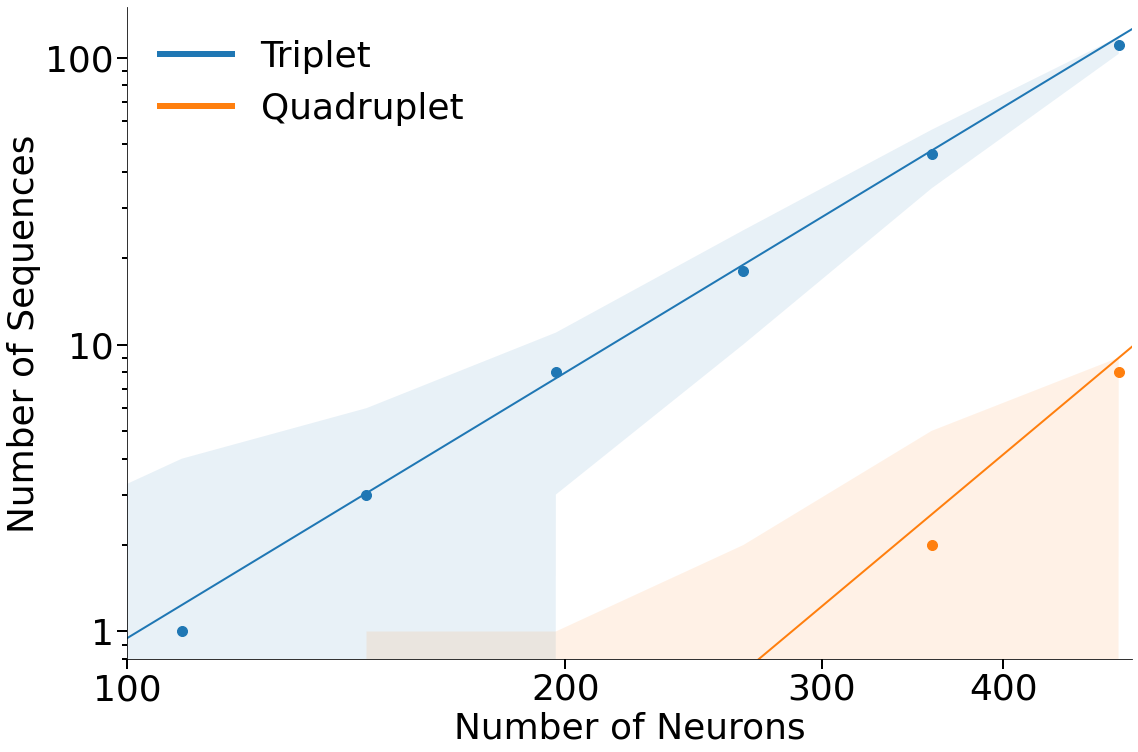

In [23]:
fig, ax = plt.subplots(figsize = (18,12))
ax.tick_params(axis='both', which='minor', labelsize=36, length=10, width=2)
ax.tick_params(axis='both', which='major', labelsize=36, length=10, width=2)
ax.tick_params(axis='y', which='minor', labelsize=24, length=5, width=2)


right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

labels = ['Triplet', 'Quadruplet']
colors = ['tab:blue', 'tab:orange', 'tab:green']
for k,p in enumerate([3, 4]):
    data = np.percentile(cts[k], [5, 50, 95], axis=1)
    
    means = cts[k].mean(axis = 1)
    print(data.shape)
    stds = cts[k].std(axis=1)
    means_lower = np.clip(means - stds, 0, None)
    means_upper = means + stds
    plt.scatter(ns, data[1], s = 100, color = colors[k])
    plt.fill_between(ns, data[0], data[2], alpha = 0.1)
    
    b = coefs_and_inters[k][0]
    a = coefs_and_inters[k][1]
    if k == 0:
        x = np.linspace(100,500, 100)
        y = np.exp(a) * x**(b)
    if k == 1:
        x = np.linspace(250,500, 100)
        y = np.exp(a) * x**(b)
    if k == 2:
        x = np.linspace(450,500, 100)
        y = np.exp(a) * x**(b)
    plt.plot(x, y, color = colors[k], label = labels[k], linewidth=2)


plt.xscale('log')
plt.yscale('log')
leg = ax.legend()

leg = plt.legend(fontsize = 36, frameon=False)
leg.get_lines()[0].set_linewidth(6)
leg.get_lines()[1].set_linewidth(6)
    
plt.xlim([100, 490])
plt.ylim([0.8, 150])
plt.xlabel('Number of Neurons', fontsize = 36)
plt.ylabel('Number of Sequences', fontsize = 36)

ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.xaxis.get_minor_formatter().set_scientific(False)
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(False)
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)

plt.savefig('lol', bbox_inches = 'tight')
plt.show()

In [ ]:
cts[2].mean(axis=1)

In [ ]:
cts[1].mean(axis=1)

In [ ]:
cts[0].mean(axis=1)

In [ ]:
print(ns)

In [ ]:
x = np.linspace(0,500,100)
y = 3.07332278*x - 14.20561333
plt.plot(x, y, '-r', label='y=mx+b')
plt.title('Graph of')
plt.xlabel('x', color='#1C2833')
plt.ylabel('y', color='#1C2833')
plt.legend(loc='upper left')
plt.grid()
plt.show()

### calculate pairwise distances for a selected seq syps

post syp neuron ending with 018 (but the post syp neuron is an "inhibitary" neuron based on the dataset but it's not proofreaded)

syps voxel pos:

(310682, 157938, 20942)

(310202, 158624, 20948)

(309638, 159332, 20949)

In [319]:
syps_voxel_pos = np.matrix([[310682, 157938, 20942], 
                           [310202, 158624, 20948],
                           [309638, 159332, 20949]])

In [320]:
conversion_array = np.array([4, 4, 40])
syp_xyz_pos = np.empty_like(syps_voxel_pos)
for i in range(np.shape(syps_voxel_pos)[0]):
    syp_xyz_pos[i] = np.multiply(syps_voxel_pos[i], conversion_array)

In [321]:
syp_xyz_pos

matrix([[1242728,  631752,  837680],
        [1240808,  634496,  837920],
        [1238552,  637328,  837960]])

In [322]:
row_0_1_dist = np.linalg.norm((syp_xyz_pos[0] - syp_xyz_pos[1]))
row_0_2_dist = np.linalg.norm((syp_xyz_pos[0] - syp_xyz_pos[2]))
row_1_2_dist = np.linalg.norm((syp_xyz_pos[1] - syp_xyz_pos[2]))

In [323]:
print(row_0_1_dist/1000)
print(row_0_2_dist/1000)
print(row_1_2_dist/1000)

3.3576086728503665
6.972026391229454
3.620961198356039


post syp neuron ending with 754 (all the neurons are excit.)

(296066, 178458, 23879)

(296571, 178627, 23896)


(297712, 178328, 23881)

In [328]:
syp_voxel_pos_2 = np.matrix([[296066, 178458, 23879], 
                           [296571, 178627, 23896],
                           [297712, 178328, 23881]])

conversion_array = np.array([4, 4, 40])
syp_xyz_pos_2 = np.empty_like(syp_voxel_pos_2)
for i in range(np.shape(syp_voxel_pos_2)[0]):
    syp_xyz_pos_2[i] = np.multiply(syp_voxel_pos_2[i], conversion_array)

row_0_1_dist_2 = np.linalg.norm((syp_xyz_pos_2[0] - syp_xyz_pos_2[1]))
row_0_2_dist_2 = np.linalg.norm((syp_xyz_pos_2[0] - syp_xyz_pos_2[2]))
row_1_2_dist_2 = np.linalg.norm((syp_xyz_pos_2[1] - syp_xyz_pos_2[2]))

print(row_0_1_dist_2/1000)
print(row_0_2_dist_2/1000)
print(row_1_2_dist_2/1000)

2.236017889016096
6.60498720664923
4.756102606126155
